In [1]:
# Package import cell

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
# Load merged tornadoes+income+density data and view all columns

pd.set_option('display.max_columns', None)
data = pd.read_csv('Merged-Tornadoes.csv',index_col = 0)
data.columns

Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE',
       'State FIPS Code', 'Name', 'Median Household Income', 'Geographic area',
       'Geographic area.1',
       'Density per square mile of land area - 

In [3]:
# Create a single unique 'STATE: COUNTY' column and trim redundant geographic columns

data['STATE: COUNTY'] = data['STATE'].map(str)+': '+data['CZ_NAME']

data = data.drop(columns=['STATE', 'STATE_FIPS', 'CZ_FIPS', 'CZ_NAME',
                        'State FIPS Code', 'Name', 'Geographic area', 'Geographic area.1'])

In [4]:
data['INJURIES_DIRECT'] = pd.to_numeric(data['INJURIES_DIRECT'])
data['INJURIES_INDIRECT'] = pd.to_numeric(data['INJURIES_INDIRECT'])
data['DEATHS_DIRECT'] = pd.to_numeric(data['DEATHS_DIRECT'])
data['DEATHS_INDIRECT'] = pd.to_numeric(data['DEATHS_INDIRECT'])

In [5]:
# Remove columns that are not useful (e.g., 'EVENT TYPE' is now only Tornado)

data = data.drop(columns=['EVENT_TYPE', 'FLOOD_CAUSE', 'CATEGORY',
                          'END_YEARMONTH', 'BEGIN_YEARMONTH', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE',
                          'END_DATE_TIME', 'CZ_TYPE', 'WFO','DATA_SOURCE',
                          'BEGIN_DAY', 'END_DAY', 'END_TIME', 'EPISODE_ID', 'DAMAGE_CROPS'])

In [6]:
data["CASUALTIES"] = data["INJURIES_INDIRECT"] + data["INJURIES_DIRECT"] + data["DEATHS_DIRECT"] + data["DEATHS_INDIRECT"]
data = data.drop(columns=["INJURIES_INDIRECT", "INJURIES_DIRECT", "DEATHS_INDIRECT", "DEATHS_DIRECT"])
data = data.drop(columns=["TOR_OTHER_WFO", "TOR_OTHER_CZ_STATE", "TOR_OTHER_CZ_FIPS", "TOR_OTHER_CZ_NAME", 'MAGNITUDE', 'MAGNITUDE_TYPE'])

In [7]:
# subset of data for baseline model
data = data.drop(columns=['MONTH_NAME','SOURCE','EPISODE_NARRATIVE','EVENT_NARRATIVE','BEGIN_LOCATION','END_LOCATION','BEGIN_AZIMUTH','END_AZIMUTH','STATE: COUNTY'])

### Converting F_Scale

In [8]:
data = data[data['TOR_F_SCALE'] != 'EFU']

In [9]:
data['TOR_F_SCALE'] = data['TOR_F_SCALE'].map(lambda x: int(x.lstrip('EF')))

In [10]:
# translates EF scores to 1 ("violent", for EF2+) or 0 (nonviolent, for EF0,1)
def makeEFBinary(ef):
    if ef <= 1:
        return 0
    elif ef <= 5:
        return 1
    else:
        assert False

data["TOR_INTENSITY"] = data["TOR_F_SCALE"].map(makeEFBinary).copy()
data[["TOR_F_SCALE", "TOR_INTENSITY"]]

,TOR_F_SCALE,TOR_INTENSITY
0,1,0
1,0,0
2,1,0
3,0,0
4,1,0
5,0,0
6,0,0
7,0,0
8,1,0
9,0,0


### Converting to sin and cos time

Here we are creating sin_time and cos_time to correctly convey the cyclical nature of time. 0001 and 2359 are 2 minutes apart and we want the model to understand that. Converting to sin_time or cos_time alone doesn't solve the problem as the sin and cos function are symmetrical and 2 different times can be represented by the same sin or cos value. Hence, we use both the sin and cos functions to create a unique cyclical value for each event.
<br> <br>
Reference: https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

In [11]:
# Check if 24 hour clock
print(data['BEGIN_TIME'].max())

2359


In [12]:
hours_in_a_day = 2400
data['sin_time'] = np.sin(2*np.pi*data.BEGIN_TIME/hours_in_a_day)
data['cos_time'] = np.cos(2*np.pi*data.BEGIN_TIME/hours_in_a_day)

### This visual illustrates how time is represented.

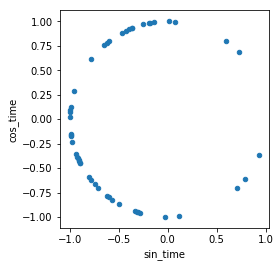

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

data.sample(50).plot.scatter('sin_time','cos_time').set_aspect('equal')
plt.show()

In [14]:
data = data.set_index('EVENT_ID')

In [15]:
#Checking for NaN values
data.isna().sum()

BEGIN_TIME                                                 0
YEAR                                                       0
DAMAGE_PROPERTY                                         1610
TOR_F_SCALE                                                0
TOR_LENGTH                                                 0
TOR_WIDTH                                                  0
BEGIN_RANGE                                                0
END_RANGE                                                  0
BEGIN_LAT                                                  0
BEGIN_LON                                                  0
END_LAT                                                    0
END_LON                                                    0
Median Household Income                                  543
Density per square mile of land area - Population        576
Density per square mile of land area - Housing units     576
CASUALTIES                                                 0
TOR_INTENSITY           

### Cleaning target variable DAMAGE_PROPERTY

In [16]:
data['DAMAGE_PROPERTY'] = data['DAMAGE_PROPERTY'].str.replace('.00K','000')
data['DAMAGE_PROPERTY'] = data['DAMAGE_PROPERTY'].str.replace('.00M','000')

In [17]:
def convert_to_billions (value):
    value = value[:-1]
    value = float(value) * 1000000000
    return value

In [18]:
def convert_to_millions (value):
    value = value[:-1]
    value = float(value) * 1000000   
    return value

In [19]:
def convert_to_thousands (value):
    value = value[:-1]
    value = float(value) * 1000 
    return value

In [20]:
data.loc[data['DAMAGE_PROPERTY'].str.endswith('B') == True,'DAMAGE_PROPERTY'] = data.loc[data['DAMAGE_PROPERTY'].str.endswith('B') == True,'DAMAGE_PROPERTY'].apply(convert_to_billions)
data.loc[data['DAMAGE_PROPERTY'].str.endswith('M') == True,'DAMAGE_PROPERTY'] = data.loc[data['DAMAGE_PROPERTY'].str.endswith('M') == True,'DAMAGE_PROPERTY'].apply(convert_to_millions)
data.loc[data['DAMAGE_PROPERTY'].str.endswith('K') == True,'DAMAGE_PROPERTY'] = data.loc[data['DAMAGE_PROPERTY'].str.endswith('K') == True,'DAMAGE_PROPERTY'].apply(convert_to_thousands)

print(data['DAMAGE_PROPERTY'].str.endswith('B').sum())
print(data['DAMAGE_PROPERTY'].str.endswith('K').sum())
print(data['DAMAGE_PROPERTY'].str.endswith('M').sum())

0
0
0


In [21]:
# Calculating mean of DAMAGE_PROPERTY for filling NaN values
# Step 1: Converting DAMAGE_PROPERTY to float 
data['DAMAGE_PROPERTY'] = data['DAMAGE_PROPERTY'].astype(float)
# Step 2: Skip NaN values when calculating mean
mean_DAMAGE_PROPERTY = data['DAMAGE_PROPERTY'].mean(skipna = True)
# Step 3: Filling NaN values
data['DAMAGE_PROPERTY'] = data['DAMAGE_PROPERTY'].fillna(mean_DAMAGE_PROPERTY)

### Cleaning other columns

In [22]:
# Calculating average of begin range and end range, which is a proxy for distance from population center
data['AVG_RANGE'] = data.loc[: , ['BEGIN_RANGE','END_RANGE']].mean(axis = 1)
data['MIN_RANGE'] = data.loc[: , ['BEGIN_RANGE','END_RANGE']].min(axis = 1)

In [23]:
data["AVG_LAT"] = (data.BEGIN_LAT + data.END_LAT)/2
data["AVG_LON"] = (data.BEGIN_LON + data.END_LON)/2

In [24]:
# Calculating mean of Median_Household_Income for filling NaN values
# Step 1: Remove commas from Median_Household_Income, converting it to float 
data['Median Household Income'] = data['Median Household Income'].str.replace(",", "").astype(float)
# Step 2: Skip NaN values when calculating mean
mean_Median_Household_Income = data['Median Household Income'].mean(skipna = True)
# Step 3: Filling NaN values
data['Median Household Income'] = data['Median Household Income'].fillna(mean_Median_Household_Income)

In [25]:
# Renamed Density per square mile of land area - Population and Density per square mile of land area - Housing units
data = data.rename(columns={'Density per square mile of land area - Population': 'Pop_Density','Density per square mile of land area - Housing units': 'Housing_Units_Density'})

In [26]:
# Calculating mean of Pop_Density for filling NaN values
# Step 1: Converting Pop_Density to float 
data['Pop_Density'] = data['Pop_Density'].astype(float)
# Step 2: Skip NaN values when calculating mean
mean_Pop_Density = data['Pop_Density'].mean(skipna = True)
# Step 3: Filling NaN values
data['Pop_Density'] = data['Pop_Density'].fillna(mean_Pop_Density)

In [27]:
# Calculating mean of Housing_Units_Density for filling NaN values
# Step 1: Converting Pop_Density to float 
data['Housing_Units_Density'] = data['Housing_Units_Density'].astype(float)
# Step 2: Skip NaN values when calculating mean
mean_Housing_Units_Density = data['Housing_Units_Density'].mean(skipna = True)
# Step 3: Filling NaN values
data['Housing_Units_Density'] = data['Housing_Units_Density'].fillna(mean_Housing_Units_Density)

In [28]:
#Checking for NaN values
data.isna().sum()

BEGIN_TIME                 0
YEAR                       0
DAMAGE_PROPERTY            0
TOR_F_SCALE                0
TOR_LENGTH                 0
TOR_WIDTH                  0
BEGIN_RANGE                0
END_RANGE                  0
BEGIN_LAT                  0
BEGIN_LON                  0
END_LAT                    0
END_LON                    0
Median Household Income    0
Pop_Density                0
Housing_Units_Density      0
CASUALTIES                 0
TOR_INTENSITY              0
sin_time                   0
cos_time                   0
AVG_RANGE                  0
MIN_RANGE                  0
AVG_LAT                    0
AVG_LON                    0
dtype: int64

In [29]:
# Final dropping of columns used to calculate new columns but not ultimately wanted or needed beyond that
data = data.drop(columns=["BEGIN_TIME", "TOR_F_SCALE", "BEGIN_RANGE", "END_RANGE", "BEGIN_LAT", "BEGIN_LON", "END_LAT", "END_LON"])

__Changes made__:
- 'BEGIN_DAY' - drop for now (maybe eventually change to out of 365)
- 'BEGIN_TIME' - check if 24 hours - and normalize with cosine
- 'EPISODE_ID' - drop for now
- 'EVENT_ID' - make index
- 'YEAR' - not scaling for decision tree, can scale for other models
- 'DAMAGE_CROPS' - drop for now
- 'TOR_F_SCALE' - Convert to violent (EF2+ ==> 1) and nonviolent (EF0, EF1 ==> 0) and store as 'TOR_INTENSITY' (target variable); drop 'TOR_F_SCALE' because it is determined after the fact
-  New column averaging 'BEGIN_RANGE' and 'END_RANGE'
- 'Median Household Income' - use average for NaNs
- 'Density per square mile of land area - Population' - use average for NaNs
- 'Density per square mile of land area - Housing units'- use average for NaNs
- 'DAMAGE_PROPERTY' - secondary target variable
<br><br>


In [30]:
data.to_csv('Cleaned-Tornadoes_v2.csv')
data

,YEAR,DAMAGE_PROPERTY,TOR_LENGTH,TOR_WIDTH,Median Household Income,Pop_Density,Housing_Units_Density,CASUALTIES,TOR_INTENSITY,sin_time,cos_time,AVG_RANGE,MIN_RANGE,AVG_LAT,AVG_LON
EVENT_ID,,,,,,,,,,,,,,,
199172,2009,7.500000e+04,3.32,75.0,45455.000000,104.600000,43.500000,0,0,-0.993670,-0.112336,2.0,2.0,33.47600,-94.42700
203900,2009,3.500000e+04,0.09,80.0,41791.000000,47.000000,31.200000,0,0,-0.649448,0.760406,2.0,2.0,45.01000,-124.01000
203474,2009,0.000000e+00,0.25,20.0,33839.000000,58.000000,27.100000,0,0,-0.743145,-0.669131,0.0,0.0,37.62630,-83.96440
203005,2009,0.000000e+00,2.67,75.0,49574.816003,173.203999,74.618833,0,0,0.892192,0.451656,3.0,2.0,31.60350,-93.49825
202997,2009,1.000000e+05,5.96,150.0,49574.816003,173.203999,74.618833,0,0,0.838671,-0.544639,3.5,2.0,32.80500,-92.51000
167751,2009,5.000000e+03,7.86,100.0,70982.000000,111.800000,46.400000,0,0,-0.993068,0.117537,1.0,1.0,36.96765,-76.71230
146677,2009,0.000000e+00,3.18,220.0,39642.000000,85.000000,36.200000,0,0,-0.924878,0.380263,8.0,7.0,33.64000,-82.55650
200666,2009,0.000000e+00,2.76,50.0,49574.816003,173.203999,74.618833,0,0,0.985996,0.166769,2.5,1.0,32.04685,-93.22120
147391,2009,2.500000e+06,1.60,200.0,37575.000000,16.300000,7.800000,0,0,-0.969231,-0.246153,0.5,0.0,31.27205,-88.01875


### Baseline Model

In [31]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(data[data.columns[data.columns != 'CASUALTIES']], data[data.columns[data.columns == 'CASUALTIES']], test_size=0.5)